<a href="https://colab.research.google.com/github/ffabi/AssettoCorsaSelfDriving/blob/master/AssettoCorsaSelfDriving.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from sklearn import preprocessing
from keras.preprocessing.image import img_to_array, ImageDataGenerator
import random
from tensorflow import set_random_seed
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation, Dense, Dropout, Flatten, Conv2D, BatchNormalization
from keras.models import Sequential, load_model
from keras.optimizers import Adam

from keras.callbacks import EarlyStopping, ModelCheckpoint

In [0]:
np.random.seed(1234)
set_random_seed(1234)

#Connect to google drive

In [35]:
from google.colab import drive 
drive.mount('/content/gdrive')

#change working directory to google drive
import os
os.chdir("gdrive/My Drive/AssettoCorsaSelfDriving")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


FileNotFoundError: ignored

In [0]:
!unzip original.zip

Archive:  original.zip
  inflating: Assetto Corsa 2019-01-06 14-58-01.mp4  


In [0]:
!mv *.mp4 videostream.mp4

In [36]:
!ls

frames	log.txt  original.zip  videostream.mp4


In [0]:
startframe = 153
endframe = 2284

In [0]:
cap = cv2.VideoCapture('videostream.mp4')

for i in range(startframe):
    cap.read()

In [0]:
framecounter=0

while framecounter < endframe - startframe:
    ret, frame = cap.read()
    cropped = frame[250:]
    cv2.imwrite("frames/frame_" + str(framecounter) + ".png", cropped)
    framecounter += 1

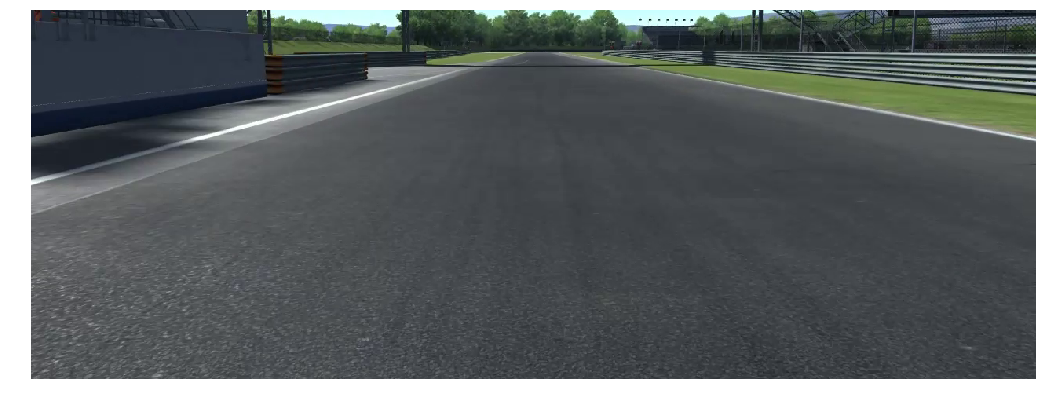

In [0]:
ret, frame = cap.read()

bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
fig=plt.figure(figsize=(18, 10))

plt.imshow(bgr[250:])
plt.axis('off')
plt.show()

In [0]:
framecounter=2131

In [0]:
# dataset = np.zeros((framecounter, ), dtype=[('steer', np.float32), ('brake', np.float32), ("gas", np.float32), ("frame", np.int16)])
dataset = np.zeros(framecounter, dtype=[('data', np.float32, 3), ('frame', np.int16, 1)])

In [0]:
metafile = open("log.txt")

for i in range(framecounter):
    values = metafile.readline().split(";")
    
    steer = values[0]
    brake = values[1]
    gas = values[2]
    
    dataset[i]["data"] = (steer, brake, gas)
    dataset[i]["frame"] = i
    
    #the metafile contains an additional line
    metafile.readline()

metafile.close()

In [83]:
dataset

array([([-2.2473795,  0.       ,  1.       ],    0),
       ([-2.308914 ,  0.       ,  1.       ],    1),
       ([-2.7570264,  0.       ,  1.       ],    2), ...,
       ([-2.8505955,  0.       ,  1.       ], 2128),
       ([-2.8630824,  0.       ,  1.       ], 2129),
       ([-2.8000185,  0.       ,  1.       ], 2130)],
      dtype=[('data', '<f4', (3,)), ('frame', '<i2')])

In [0]:
np.random.shuffle(dataset)

In [85]:
dataset

array([([ 1.2674533 ,  0.9280783 ,  0.        ], 1336),
       ([-2.738019  ,  0.        ,  1.        ],  318),
       ([-0.3142755 ,  0.        ,  1.        ], 1142), ...,
       ([17.811192  ,  0.7250366 ,  0.33600003], 1378),
       ([62.335247  ,  0.        ,  0.88366926], 1849),
       ([19.940302  ,  0.6232712 ,  0.        ],   96)],
      dtype=[('data', '<f4', (3,)), ('frame', '<i2')])

In [86]:
valid_split = 0.2
test_split = 0.1

train = dataset[0:int(framecounter*(1-valid_split-test_split))]
valid = dataset[int(framecounter*(1-valid_split-test_split)):int(framecounter*(1-test_split))]
test  = dataset[int(framecounter*(1-test_split)):]

print(len(train))

1491


In [92]:
#standard scaler
scaler = preprocessing.MinMaxScaler().fit(train["data"])
train["data"] = scaler.transform(train["data"])
valid["data"] = scaler.transform(valid["data"])
test["data"] = scaler.transform(test["data"])
train

array([([0.46631038, 0.9280783 , 0.        ], 1336),
       ([0.4496113 , 0.        , 1.        ],  318),
       ([0.45971605, 0.        , 1.        ], 1142), ...,
       ([0.45736846, 0.        , 1.        ], 1096),
       ([0.4107014 , 0.        , 1.        ],  530),
       ([0.85396767, 0.        , 0.11596119],  933)],
      dtype=[('data', '<f4', (3,)), ('frame', '<i2')])

In [0]:
import numpy as np
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
class DataGenerator(keras.utils.Sequence):
    """Generates data for Keras"""

    def __init__(self, dataset, dim, batch_size=10, shuffle=True):
        """Initialization"""
        self.dim = dim
        self.batch_size = batch_size
        self.dataset = dataset
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))
        self.on_epoch_end()
        

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return int(np.floor(len(self.dataset) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data"""
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        ids = [self.dataset["frame"][k] for k in indexes]
        datapoints = [self.dataset["data"][k] for k in indexes]

        """Generates data containing batch_size samples"""
        # Initialization
        
        X = np.empty((self.batch_size, *self.dim), dtype=float)
        Y = np.empty((self.batch_size, *(3, )), dtype=float)
        # Generate data
        for i, ID in enumerate(ids):
            img = img_to_array(load_img('frames/frame_' + str(ID) + '.png'))
            img = img / 255
            
            
            # Store sample
            X[i,] = img
            
            # Store data
            Y[i,] = datapoints[i]

        return X, Y

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle:
            np.random.shuffle(self.indexes)


In [0]:

# class Swish(Activation):
    
#     def __init__(self, activation, **kwargs):
#         super(Swish, self).__init__(activation, **kwargs)
#         self.__name__ = 'swish'

# def swish(x):
#     A = (K.sigmoid(x) * x)
#     return A

# get_custom_objects().update({'swish': Swish(swish)})

In [0]:
img_shape = (470, 1280, 3)

In [0]:
model = Sequential([
        Conv2D(24, kernel_size=(5,5), strides=(2,2), activation='relu', input_shape=img_shape),
        BatchNormalization(),
        Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='relu'),
        BatchNormalization(),
        Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='relu'),
        BatchNormalization(),
        Conv2D(64, kernel_size=(3,3), strides=(1,1), activation='relu'),
        BatchNormalization(),
        Conv2D(64, kernel_size=(3,3), strides=(1,1), activation='relu'),
        BatchNormalization(),
        Conv2D(84, kernel_size=(3,3), strides=(1,1), activation='relu'),
        BatchNormalization(),
        Flatten(),
        Dense(100, activation='relu'),
        BatchNormalization(),
        Dense(50, activation='relu'),
        BatchNormalization(),
        Dense(10, activation='relu'),
        BatchNormalization(),
        Dense(3)
    ])

In [165]:
model.compile(optimizer="adam", loss="mse", metrics=['mae', 'acc'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 233, 638, 24)      1824      
_________________________________________________________________
batch_normalization_28 (Batc (None, 233, 638, 24)      96        
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 115, 317, 36)      21636     
_________________________________________________________________
batch_normalization_29 (Batc (None, 115, 317, 36)      144       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 56, 157, 48)       43248     
_________________________________________________________________
batch_normalization_30 (Batc (None, 56, 157, 48)       192       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 54, 155, 64)       27712     
__________

In [0]:
def plot_history(network_history):
    
    #set pltting attributes
    #loss-epochs
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    #accuracy-epochs
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['acc'])
    plt.plot(network_history.history['val_acc'])
    plt.legend(['Training', 'Validation'])
    
    plt.show()

In [166]:
training_generator = DataGenerator(train, dim=img_shape)
validation_generator = DataGenerator(valid, dim=img_shape)

#setup early stopping
es = EarlyStopping(patience=5, verbose=1, min_delta=0.005)

#we are going to keep only the best model
mcp = ModelCheckpoint(filepath='weights.hdf5', verbose=1, save_best_only=True)

# set parameters and start learning
history = model.fit_generator(
            generator=training_generator,
            validation_data=validation_generator,
            use_multiprocessing=True,
          epochs=10, # early stopping detects the end
          verbose=1, 
          shuffle=True,
          callbacks=[mcp, es]
         )

Epoch 1/10
149/149 [==============================] - 152s 1s/step - loss: 0.4319 - mean_absolute_error: 0.4872 - acc: 0.4477 - val_loss: 0.6814 - val_mean_absolute_error: 0.5600 - val_acc: 0.2310

Epoch 00001: val_loss improved from inf to 0.68145, saving model to weights.hdf5
Epoch 2/10
149/149 [==============================] - 128s 857ms/step - loss: 0.1142 - mean_absolute_error: 0.2561 - acc: 0.5993 - val_loss: 0.0922 - val_mean_absolute_error: 0.2258 - val_acc: 0.6619

Epoch 00002: val_loss improved from 0.68145 to 0.09220, saving model to weights.hdf5
Epoch 3/10
149/149 [==============================] - 132s 886ms/step - loss: 0.0757 - mean_absolute_error: 0.2053 - acc: 0.6805 - val_loss: 0.0554 - val_mean_absolute_error: 0.1730 - val_acc: 0.7452

Epoch 00003: val_loss improved from 0.09220 to 0.05541, saving model to weights.hdf5
Epoch 4/10
149/149 [==============================] - 135s 908ms/step - loss: 0.0740 - mean_absolute_error: 0.2015 - acc: 0.6859 - val_loss: 0.2390 -

In [0]:
# load back best model (early stopping + model checkpoint)
model = load_model('weights.hdf5')

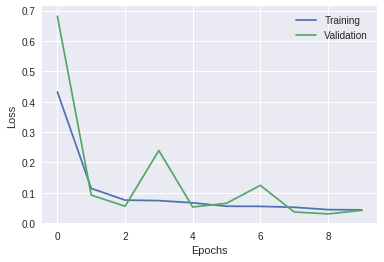

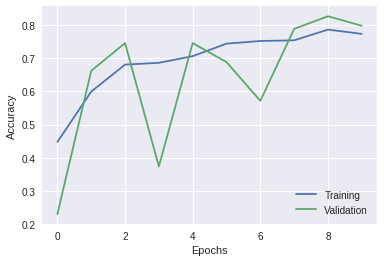

Test accuracy: 84.29%


In [172]:
#plot learning history
plot_history(history)

# Final evaluation of the model
test_generator = DataGenerator(test, dim=img_shape)
scores = model.evaluate_generator(test_generator, verbose=0)
print("Test accuracy: %.2f%%" % (scores[2]*100))